In [1]:
import os
import pandas as pd
from nlpipe import NlPipe
import numpy as np
import os
from tqdm.auto import tqdm
import logging
from threadpoolctl import threadpool_limits
import pickle
from IPython.display import display
from IPython.core.display import HTML
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.wrappers import LdaMallet
import pyLDAvis
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array
path = "b_collection_extracted/"

## Ausgabe berechneter Coherence Scores

In [2]:
with open(f"{path}coherence_results_mallet", "rb") as f:
    coherences = pickle.load(f)

In [3]:
coherences

{'mallet-no=5-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.4812077964460986},
 'best_score': 0.5421969031049485,
 'best_model': <gensim.models.wrappers.ldamallet.LdaMallet at 0x7fc918ec8dd8>,
 'best_topic_no': 20,
 'best_alpha': array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]),
 'mallet-no=10-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5101931898288266},
 'mallet-no=15-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5122058451092564},
 'mallet-no=20-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5421969031049485},
 'mallet-no=25-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5154006518971267},
 'mallet-no=30-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5317904529441941},
 'mallet-no=35-filter=True-min_

## Mallet LDA mit 20 Topics

Bestes Model nach Score ist bei 20 Topics

In [4]:
stat_df = pd.read_pickle(f"{path}stat_df")
if os.path.exists(f"{path}text_df"):
    print("text df found. loading.")
    text_df = pd.read_pickle(f"{path}text_df")
    texts = text_df.full_text.to_list()
    thread_ids = text_df.thread_id.to_list()
else:
    thread_ids = stat_df.thread_id.to_list()
    post_df = pd.read_pickle(f"{path}post_df_extracted")
    thread_id_of_posts = np.array(post_df.thread_id, dtype=np.uint32)
    texts = [" ".join(post_df.full_string[thread_id_of_posts == thread_id].tolist()) for thread_id in thread_ids]
    post_df = None
    text_df = pd.DataFrame([thread_ids, texts]).transpose()
    text_df.columns = ['thread_id', 'full_text']
    text_df.to_pickle(f"{path}text_df")

text df found. loading.


Um das Modell erneut zu trainieren, folgende Zelle ausführen. 

In [5]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)

nlp.create_mallet_lda_model(no_topics=20, custom_prefix="20tops")
coherence_mallet = nlp.calculate_coherence()
coherence_mallet = coherence_mallet.get_coherence()
print(f"Coherence score for MALLET in this run is {coherence_mallet}")

326538 is limiting to 105100
Found preprocessed data. Loading
105100 preprocessed docs of 326538 docs loaded.


Creating bag of words:   0%|          | 0/105100 [00:00<?, ?it/s]

Coherence score for MALLET in this run is 0.5086942988836909


Um das trainierte Modell erneut zu laden, folgende Zelle ausführen. 

In [ ]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)
nlp.lda_model = LdaMallet.load("b_collection_extracted/mallet_model_20_topics")

In [6]:
# mallet with 20 topics
for topic_no, word_list in nlp.lda_model.show_topics(num_topics=20, num_words= 30, formatted=False):
    print(topic_no, [word[0] for word in word_list])

0 ['eat', 'drink', 'water', 'food', 'smell', 'fat', 'taste', 'clean', 'meat', 'cook', 'piss', 'toilet', 'chicken', 'pizza', 'beer', 'sauce', 'buy', 'cut', 'wash', 'milk', 'cheese', 'skin', 'egg', 'grow', 'bite', 'tooth', 'poop', 'dry', 'fish', 'bottle']
1 ['dog', 'retard', 'kill', 'kek', 'bitch', 'lose', 'funny', 'kid', 'kys', 'fucking', 'dude', 'loser', 'fag', 'laugh', 'meme', 'animal', 'stupid', 'cat', 'die', 'dead', 'chan', 'joke', 'dad', 'cunt', 'father', 'cringe', 'nigga', 'late', 'mother', 'lmao']
2 ['trump', 'vote', 'retard', 'president', 'country', 'american', 'state', 'tds', 'liberal', 'biden', 'win', 'government', 'america', 'party', 'stupid', 'democrat', 'republican', 'support', 'obama', 'literally', 'news', 'political', 'wrong', 'point', 'lose', 'fact', 'lie', 'conservative', 'medium', 'idiot']
3 ['kik', 'send', 'gf', 'wife', 'nude', 'share', 'cock', 'trade', 'cum', 'slut', 'rate', 'teen', 'vids', 'sister', 'limit', 'cuck', 'tribute', 'snap', 'jerk', 'wanna', 'chat', 'add',

In [7]:
nlp.create_document_topic_df(model=nlp.lda_model)
nlp.result_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,dominant_topic
830097224,0.037051,0.022928,0.018190,0.000000,0.329149,0.020258,0.040648,0.051258,0.027013,0.101536,...,0.017634,0.019684,0.035785,0.019994,0.085983,0.058109,0.073910,0.016372,0.011472,4
828635931,0.049020,0.049020,0.049020,0.049182,0.068408,0.049020,0.049020,0.049020,0.049020,0.049020,...,0.049020,0.049020,0.049020,0.049077,0.049020,0.049020,0.049020,0.049020,0.049020,4
828806746,0.032071,0.038633,0.072025,0.028706,0.030556,0.036756,0.037267,0.030372,0.174993,0.029719,...,0.031602,0.028098,0.033879,0.028831,0.056091,0.027797,0.027767,0.042066,0.034995,10
828629011,0.014446,0.251060,0.013481,0.059829,0.141474,0.030384,0.141135,0.023445,0.000000,0.045071,...,0.000000,0.016807,0.070335,0.036985,0.000000,0.084959,0.025231,0.000000,0.000000,1
828822496,0.028662,0.055851,0.128970,0.061233,0.113967,0.030103,0.038423,0.032932,0.038147,0.071043,...,0.026983,0.055526,0.061635,0.047417,0.046824,0.036337,0.028205,0.040844,0.024882,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831569096,0.039164,0.031775,0.028262,0.025739,0.031378,0.111469,0.023536,0.027176,0.071944,0.027165,...,0.052872,0.033063,0.114090,0.033593,0.030401,0.029690,0.208559,0.025085,0.025788,17
830755068,0.000000,0.028947,0.151204,0.000000,0.000000,0.043736,0.084799,0.010438,0.028169,0.013511,...,0.047951,0.000000,0.014556,0.000000,0.041607,0.000000,0.000000,0.411854,0.000000,18
828459235,0.020987,0.020850,0.000000,0.000000,0.020736,0.245779,0.157392,0.019472,0.015906,0.320199,...,0.010821,0.000000,0.000000,0.014994,0.019865,0.000000,0.036677,0.035143,0.000000,9
828957946,0.023606,0.028881,0.013878,0.027145,0.035768,0.016553,0.031625,0.025970,0.022216,0.057812,...,0.047133,0.292078,0.059193,0.067158,0.013564,0.158725,0.022639,0.018465,0.018203,12


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,dominant_topic
830097224,0.037051,0.022927,0.018190,0.000000,0.329149,0.020256,0.040645,0.051256,0.027014,0.101533,...,0.017628,0.019684,0.035809,0.019993,0.085980,0.058108,0.073906,0.016373,0.011471,4
828635931,0.049020,0.049020,0.049020,0.049182,0.068407,0.049020,0.049020,0.049020,0.049020,0.049020,...,0.049020,0.049020,0.049020,0.049077,0.049020,0.049020,0.049020,0.049020,0.049020,4
828806746,0.032072,0.038639,0.072038,0.028706,0.030556,0.036756,0.037269,0.030373,0.174962,0.029719,...,0.031602,0.028098,0.033882,0.028831,0.056086,0.027797,0.027767,0.042068,0.034995,10
828629011,0.014445,0.251061,0.013480,0.059829,0.141473,0.030385,0.141135,0.023445,0.000000,0.045070,...,0.000000,0.016805,0.070333,0.036991,0.000000,0.084959,0.025230,0.000000,0.000000,1
828822496,0.028662,0.055856,0.128972,0.061245,0.113967,0.030103,0.038425,0.032932,0.038147,0.071050,...,0.026983,0.055517,0.061616,0.047417,0.046824,0.036338,0.028205,0.040842,0.024883,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831569096,0.039165,0.031775,0.028262,0.025739,0.031378,0.111466,0.023536,0.027176,0.071944,0.027165,...,0.052871,0.033063,0.114098,0.033593,0.030401,0.029690,0.208555,0.025085,0.025788,17
830755068,0.000000,0.028942,0.151207,0.000000,0.000000,0.043736,0.084795,0.010438,0.028169,0.013511,...,0.047950,0.000000,0.014562,0.000000,0.041606,0.000000,0.000000,0.411855,0.000000,18
828459235,0.020987,0.020850,0.000000,0.000000,0.020736,0.245780,0.157387,0.019472,0.015906,0.320200,...,0.010821,0.000000,0.000000,0.014995,0.019866,0.000000,0.036675,0.035147,0.000000,9
828957946,0.023607,0.028888,0.013879,0.027151,0.035771,0.016553,0.031625,0.025978,0.022216,0.057824,...,0.047165,0.292094,0.059149,0.067106,0.013564,0.158734,0.022646,0.018460,0.018204,12


In [8]:
nlp.result_df.to_pickle("b_collection_extracted/document_result_df_20tops")

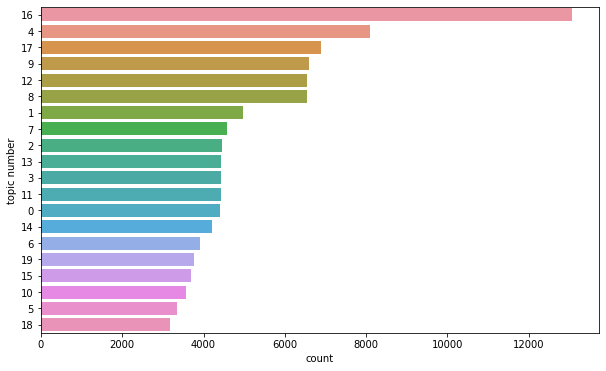

In [9]:
nlp.plot_document_topic_distribution()

In [10]:
with open("b_collection_extracted/mallet_model_20_topics", "wb") as f:
    nlp.lda_model.save(f)

In [11]:
model = malletmodel2ldamodel(nlp.lda_model)
panel = pyLDAvis.gensim.prepare(model, nlp.bag_of_words, nlp.id2word)
with open("b_collection_extracted/pyldavis20tops.html", "w") as f:
    pyLDAvis.save_html(data=panel, fileobj=f)
display(HTML(filename="b_collection_extracted/pyldavis20tops.html"))

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


## Mallet LDA mit 25 Topics

Um das Modell erneut zu trainieren, folgende Zelle ausführen. 

In [12]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)

nlp.create_mallet_lda_model(no_topics=25, custom_prefix="25tops")
coherence_mallet = nlp.calculate_coherence()
coherence_mallet = coherence_mallet.get_coherence()
print(f"Coherence score for MALLET in this run is {coherence_mallet}")

326538 is limiting to 105100
Found preprocessed data. Loading
105100 preprocessed docs of 326538 docs loaded.


Creating bag of words:   0%|          | 0/105100 [00:00<?, ?it/s]

Coherence score for MALLET in this run is 0.5252877768787874


Um das bereits trainierte Modell zu laden, folgende Zelle ausführen. 

In [ ]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)
nlp.lda_model = LdaMallet.load("b_collection_extracted/mallet_model_25_topics")

In [13]:
for topic_no, word_list in nlp.lda_model.show_topics(num_topics=25, num_words= 30, formatted=False):
    print(topic_no, [word[0] for word in word_list])

0 ['child', 'rape', 'kid', 'loli', 'age', 'sex', 'porn', 'boy', 'pedo', 'young', 'real', 'sexual', 'wrong', 'adult', 'pedophile', 'shota', 'fetish', 'stuff', 'woman', 'lolis', 'abuse', 'legal', 'consent', 'diaper', 'baby', 'pedos', 'image', 'imagine', 'illegal', 'fantasy']
1 ['game', 'play', 'watch', 'movie', 'music', 'great', 'listen', 'character', 'story', 'fun', 'end', 'song', 'read', 'cool', 'remember', 'lot', 'write', 'favorite', 'base', 'list', 'hear', 'star', 'band', 'sound', 'film', 'enjoy', 'video', 'metal', 'stuff', 'fan']
2 ['kik', 'send', 'gf', 'wife', 'nude', 'cock', 'share', 'trade', 'cum', 'slut', 'teen', 'rate', 'cuck', 'limit', 'sister', 'tribute', 'vids', 'wanna', 'chat', 'jerk', 'oc', 'stuff', 'add', 'trib', 'bonus', 'friend', 'bull', 'talk', 'snap', 'expose']
3 ['bitch', 'kek', 'lose', 'funny', 'coof', 'retard', 'dude', 'kid', 'loser', 'kys', 'fucking', 'laugh', 'dad', 'haha', 'nigga', 'fag', 'late', 'father', 'cunt', 'mother', 'meme', 'lmao', 'chan', 'joke', 'stupi

In [14]:
nlp.create_document_topic_df(model=nlp.lda_model)
nlp.result_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,dominant_topic
830097224,0.069882,0.076534,0.000000,0.022479,0.051844,0.028320,0.011417,0.017548,0.034530,0.066570,...,0.067381,0.026977,0.013597,0.013132,0.029332,0.000000,0.000000,0.010996,0.010017,12
828635931,0.058724,0.039216,0.039315,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,...,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0
828806746,0.025240,0.024693,0.023191,0.025465,0.022335,0.157147,0.030441,0.028016,0.165846,0.022658,...,0.052225,0.022290,0.031558,0.056152,0.022619,0.058254,0.029106,0.023052,0.025073,8
828629011,0.053437,0.017086,0.046074,0.184290,0.077461,0.000000,0.018914,0.049973,0.150124,0.023965,...,0.000000,0.000000,0.000000,0.000000,0.027140,0.000000,0.049649,0.021775,0.010953,3
828822496,0.118044,0.026436,0.035450,0.063474,0.026982,0.026594,0.021446,0.039645,0.027595,0.025221,...,0.033585,0.027549,0.025369,0.108135,0.036802,0.024343,0.029114,0.084837,0.024508,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831569096,0.020463,0.020579,0.021007,0.028131,0.022588,0.047008,0.112389,0.095555,0.022173,0.206631,...,0.023813,0.036129,0.020076,0.023088,0.031757,0.022851,0.019949,0.023387,0.038741,9
830755068,0.017760,0.000000,0.000000,0.024322,0.000000,0.039147,0.043475,0.011113,0.032861,0.000000,...,0.040064,0.000000,0.385584,0.140155,0.000000,0.070907,0.088001,0.000000,0.000000,18
828459235,0.000000,0.024387,0.000000,0.010963,0.000000,0.016019,0.194791,0.000000,0.022030,0.013759,...,0.018120,0.000000,0.023719,0.000000,0.297269,0.021165,0.155764,0.000000,0.000000,20
828957946,0.017050,0.014455,0.026351,0.020430,0.101422,0.015091,0.014687,0.031673,0.035531,0.015752,...,0.010223,0.296874,0.017248,0.000000,0.025955,0.000000,0.012190,0.015238,0.014456,17


In [15]:
nlp.result_df.to_pickle("b_collection_extracted/document_result_df_25tops")

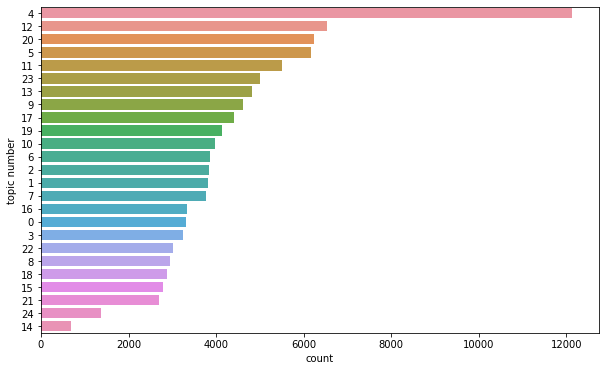

In [16]:
nlp.plot_document_topic_distribution()

In [17]:
with open("b_collection_extracted/mallet_model_25_topics", "wb") as f:
    nlp.lda_model.save(f)

In [18]:
model = malletmodel2ldamodel(nlp.lda_model)
panel = pyLDAvis.gensim.prepare(model, nlp.bag_of_words, nlp.id2word)
with open("b_collection_extracted/pyldavis25tops.html", "w") as f:
    pyLDAvis.save_html(data=panel, fileobj=f)
display(HTML(filename="b_collection_extracted/pyldavis25tops.html"))

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


## Mallet LDA mit 30 Topics

Um das Modell erneut zu trainieren, folgende Zelle ausführen. 

In [19]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)

nlp.create_mallet_lda_model(no_topics=30, custom_prefix="30tops")
coherence_mallet = nlp.calculate_coherence()
coherence_mallet = coherence_mallet.get_coherence()
print(f"Coherence score for MALLET in this run is {coherence_mallet}")

326538 is limiting to 105100
Found preprocessed data. Loading
105100 preprocessed docs of 326538 docs loaded.


Creating bag of words:   0%|          | 0/105100 [00:00<?, ?it/s]

Coherence score for MALLET in this run is 0.530990025872949


Um das bereits trainierte Modell zu laden, folgende Zelle ausführen. 

In [ ]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)
nlp.lda_model = LdaMallet.load("b_collection_extracted/mallet_model_30_topics")

In [20]:
for topic_no, word_list in nlp.lda_model.show_topics(num_topics=30, num_words= 30, formatted=False):
    print(topic_no, [word[0] for word in word_list])

0 ['drink', 'smoke', 'drug', 'wee', 'high', 'week', 'hour', 'month', 'alcohol', 'beer', 'doctor', 'lot', 'night', 'sleep', 'quit', 'live', 'trip', 'addict', 'grow', 'experience', 'water', 'coke', 'brain', 'pill', 'buy', 'meth', 'effect', 'body', 'ago', 'couple']
1 ['virus', 'die', 'death', 'coof', 'covid', 'tds', 'test', 'case', 'corona', 'mask', 'china', 'usa', 'flu', 'infect', 'spread', 'coronavirus', 'rate', 'world', 'kill', 'retard', 'wear', 'week', 'hospital', 'number', 'country', 'disease', 'sick', 'wrong', 'month', 'pandemic']
2 ['car', 'buy', 'doll', 'light', 'drive', 'build', 'space', 'lot', 'small', 'run', 'easy', 'water', 'cheap', 'cool', 'air', 'set', 'real', 'fast', 'stuff', 'window', 'earth', 'computer', 'tank', 'power', 'clean', 'flat', 'speed', 'quality', 'learn', 'model']
3 ['tit', 'nude', 'pussy', 'moar', 'damn', 'share', 'gf', 'slut', 'body', 'great', 'wife', 'spread', 'kik', 'chick', 'fat', 'interest', 'tits', 'bitch', 'bump', 'dump', 'pron', 'cute', 'wow', 'tattoo'

In [21]:
nlp.create_document_topic_df(model=nlp.lda_model)
nlp.result_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,dominant_topic
830097224,0.022968,0.000000,0.014163,0.073849,0.000000,0.000000,0.015061,0.033130,0.000000,0.053829,...,0.020352,0.000000,0.000000,0.148386,0.080371,0.076101,0.036842,0.000000,0.000000,24
828635931,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,0.032680,...,0.032680,0.032680,0.032783,0.032680,0.052084,0.032680,0.032680,0.032680,0.032680,25
828806746,0.021325,0.026119,0.024712,0.018369,0.180918,0.018291,0.079443,0.018913,0.031034,0.019949,...,0.105238,0.021485,0.019161,0.029192,0.021020,0.019856,0.018603,0.037945,0.018218,4
828629011,0.000000,0.000000,0.000000,0.126812,0.000000,0.010782,0.000000,0.021171,0.030087,0.024769,...,0.000000,0.024246,0.014295,0.174841,0.041057,0.093195,0.016630,0.000000,0.000000,24
828822496,0.018315,0.021991,0.019396,0.032662,0.020400,0.023088,0.023034,0.022112,0.068880,0.050507,...,0.018217,0.022470,0.038336,0.028421,0.090303,0.074744,0.029316,0.100310,0.017213,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831569096,0.023585,0.016085,0.037940,0.017474,0.017631,0.051464,0.018472,0.027247,0.070146,0.017614,...,0.062861,0.023252,0.019286,0.020078,0.018047,0.020833,0.053102,0.018548,0.018677,11
830755068,0.014802,0.343733,0.019570,0.000000,0.089827,0.000000,0.089164,0.000000,0.013334,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083770,0.000000,1
828459235,0.000000,0.016850,0.050688,0.000000,0.015200,0.000000,0.000000,0.000000,0.033076,0.179982,...,0.012616,0.000000,0.000000,0.017136,0.000000,0.010765,0.172033,0.000000,0.000000,19
828957946,0.011906,0.012448,0.000000,0.021644,0.000000,0.330730,0.017550,0.081135,0.010166,0.047887,...,0.013066,0.118530,0.025031,0.023122,0.014621,0.027688,0.018029,0.000000,0.000000,5


In [22]:
nlp.result_df.to_pickle("b_collection_extracted/document_result_df_30tops")

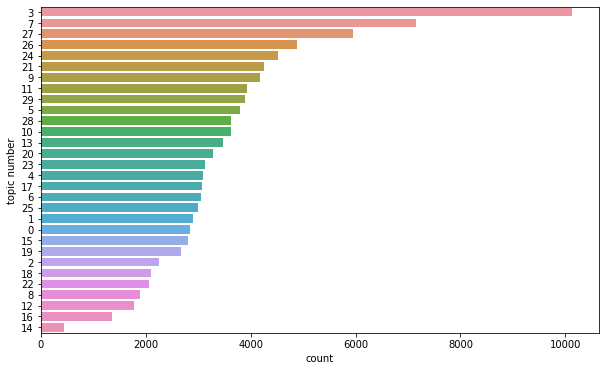

In [23]:
nlp.plot_document_topic_distribution()

In [24]:
with open("b_collection_extracted/mallet_model_30_topics", "wb") as f:
    nlp.lda_model.save(f)

In [25]:
model = malletmodel2ldamodel(nlp.lda_model)
panel = pyLDAvis.gensim.prepare(model, nlp.bag_of_words, nlp.id2word)
with open("b_collection_extracted/pyldavis30tops.html", "w") as f:
    pyLDAvis.save_html(data=panel, fileobj=f)
display(HTML(filename="b_collection_extracted/pyldavis30tops.html"))

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


## Qualitative Überprüfung des Topic Models mit 25 Topics anhand der Kurztitel der Threads

In [50]:
result_df = pd.read_pickle("b_collection_extracted/document_result_df_25tops")
stat_df_joined = stat_df[filter_on_stats(stat_df)].join(result_df.dominant_topic, on='thread_id')

In [52]:
pd.set_option('display.max_rows', 500)

In [ ]:
# Pädothreads, viel Bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 0].head(200) 

In [ ]:
#Freizeit (Musik, Spiele, Videos)
stat_df_joined[stat_df_joined.dominant_topic == 1].head(200)

In [ ]:
#viel Kik und Tributes
stat_df_joined[stat_df_joined.dominant_topic == 2].head(200)

In [ ]:
#ylyl, rekt, 
stat_df_joined[stat_df_joined.dominant_topic == 3].head(200)

In [ ]:
# social (Bildertausch)
stat_df_joined[stat_df_joined.dominant_topic == 4].head(200)

In [ ]:
#rassimus => PoC
stat_df_joined[stat_df_joined.dominant_topic == 5].head(200)

In [ ]:
#Lebenslagen/Ratschläge/Fragen/Rekt
stat_df_joined[stat_df_joined.dominant_topic == 6].head(200)

In [ ]:
#inzest/familie
stat_df_joined[stat_df_joined.dominant_topic == 7].head(200)

In [ ]:
#Rassismus
stat_df_joined[stat_df_joined.dominant_topic == 8].head(200)

In [ ]:
#teils tranny, wwyd
stat_df_joined[stat_df_joined.dominant_topic == 9].head(200)

In [ ]:
# roll
stat_df_joined[stat_df_joined.dominant_topic == 10].head(200)

In [ ]:
#psychische Krankheiten/Beziehungen/Gefühle
stat_df_joined[stat_df_joined.dominant_topic == 11].head(200)

In [ ]:
# porn-share/porn-meta/tech/picshare
stat_df_joined[stat_df_joined.dominant_topic == 12].head(200)

In [ ]:
#drogen/etwas essen
stat_df_joined[stat_df_joined.dominant_topic == 13].head(200)

In [ ]:
#grils 4bbc/bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 14].head(200)

In [ ]:
#sfur/gfur/futa(=>Anime)/caturday =>Bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 15].head(200)

In [ ]:
#jobs/geld/Corona
stat_df_joined[stat_df_joined.dominant_topic == 16].head(200)

In [ ]:
# Celebs/feet =>Bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 17].head(200)

In [ ]:
# covid
stat_df_joined[stat_df_joined.dominant_topic == 18].head(200)

In [ ]:
#Politik => Diskussion
stat_df_joined[stat_df_joined.dominant_topic == 19].head(200)

In [ ]:
#Penis/Trans/Sex (>Diskussion, in kleinen Teilen Bildertausch)
stat_df_joined[stat_df_joined.dominant_topic == 20].head(200)

In [ ]:
#Nationen
stat_df_joined[stat_df_joined.dominant_topic == 21].head(200)

In [ ]:
#wissenschaft, glauben/gemischt => Diskussion
stat_df_joined[stat_df_joined.dominant_topic == 22].head(200)

In [ ]:
#lokaler Bildertausch/hunger games
stat_df_joined[stat_df_joined.dominant_topic == 23].head(200)

In [ ]:
#Kunst/malen
stat_df_joined[stat_df_joined.dominant_topic == 24].head(200)

## K-Means Clustering der Wahrscheinlichkeitsverteilungen über die Topics

In [218]:
X = result_df.drop(columns= ["dominant_topic", "labels"])
sum_squared_distances = [] 
for i in range(1, 24): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_jobs = 20, max_iter=500)
    kmeans.fit(X) 
    sum_squared_distances.append(kmeans.inertia_)

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25

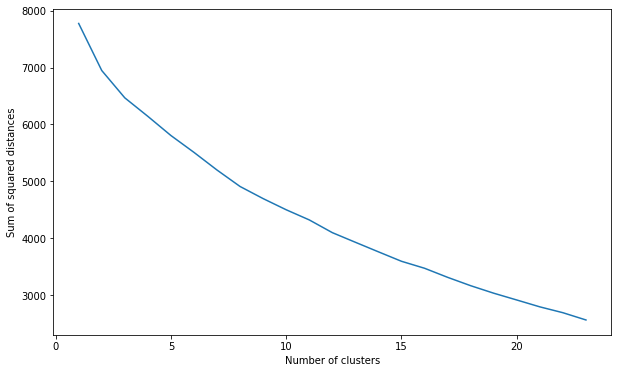

In [227]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 24), sum_squared_distances)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances') 
plt.show()

In [240]:
kmeans = KMeans(n_clusters = 8, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [241]:
result_df["km"] = y_kmeans

In [350]:
topic_dict.keys()

odict_keys([4, 0, 2, 1, 3, 6, 5, 7])

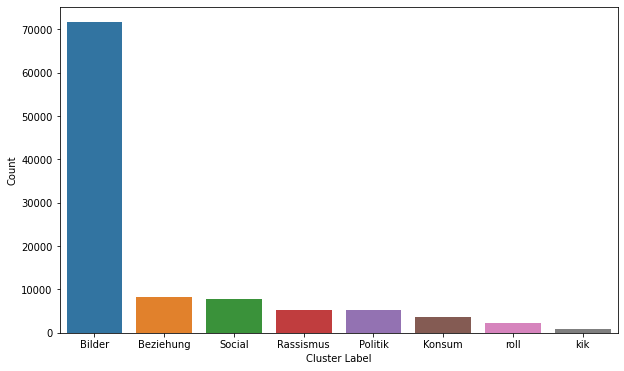

In [354]:
counter = Counter(result_df.km)
topic_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
g = sns.barplot(x=list(topic_dict.keys()), y=list(topic_dict.values()), order=list(topic_dict.keys()), orient="v")
g.set_xticklabels(labels=[["Beziehung", "Rassismus", "Social", "Politik","Bilder", "roll", "Konsum", "kik"][i] for i in topic_dict.keys()], horizontalalignment='right')

g.set_ylabel("Count")
g.set_xlabel("Cluster Label")
plt.show()


In [164]:
result_df.to_pickle("b_collection_extracted/result_df_dist_clust")

In [244]:
stat_df_joined_cluster = stat_df[filter_on_stats(stat_df)].join(result_df.km, on='thread_id')

In [305]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==0].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
31,831859941,b,how-do-i-tell-a-girl-i-like-that-i-have-a-fetish,1594438973,MISSING,23,0,0,0,en,True,13,0
99,824316167,b,i-want-to-kill-myself-lads-my-life-is-shit,1585863053,MISSING,12,3,0,0,en,True,11,0
112,829937074,b,anyone-here-try-sertralinezoloft-what-are-your,1592077057,MISSING,16,2,0,0,en,True,11,0
132,825543132,b,tell-me-what-kind-of-perv-you-are,1587167282,MISSING,33,5,0,0,en,True,13,0
187,823014636,b,would-you-really-be-surprised-if-you-found-out,1584518687,MISSING,18,2,0,0,en,True,13,0
366,828325268,b,hey-b-so-i-have-a-major-life-issue-idk-what-to-do,1590288542,MISSING,23,1,0,0,en,True,11,0
368,828749364,b,welp-this-just-happened,1590772965,MISSING,21,10,0,0,en,True,13,0
392,831311058,b,im-an-adult-and-have-asperger-ask-me-anything,1593759814,MISSING,15,0,0,0,en,True,9,0
400,831856342,b,how-attractive-do-you-have-to-be-to-be-to-be-able,1594435116,MISSING,23,0,0,0,en,True,9,0
535,830950360,b,why-get-married,1593316483,MISSING,71,6,0,0,en,True,9,0


In [304]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==1].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
11,828806746,b,apologize-white-goy,1590830943,MISSING,19,5,0,0,en,True,10,1
98,829802307,b,is-this-okay-to-say,1591918013,MISSING,35,6,0,0,en,True,8,1
171,830534517,b,wtf-is-wrong-with-this-world,1592797490,MISSING,37,7,0,0,en,True,2,1
228,829176998,b,first-i-destroy-this-pussy-then-i-destroy-your,1591224807,MISSING,48,12,0,0,en,True,8,1
255,828864604,b,its-over-america-is-ours,1590897275,MISSING,44,4,0,0,en,True,8,1
293,830654398,b,if-i-say-all-lives-matter-im-a-racist-if-i-stand,1592945216,MISSING,209,53,0,0,en,True,2,1
347,829473584,b,nigger-spear-pelters-listen-up,1591552331,MISSING,13,1,0,0,en,True,8,1
395,829012139,b,4chan-supports-black-lives-matter,1591051845,MISSING,42,16,0,0,en,True,8,1
430,830870664,b,black-lives-matter-thread,1593220161,MISSING,12,0,0,0,en,True,8,1
451,830464450,b,violent-felon-dies-while-being-arrested-for-yet,1592715373,MISSING,15,7,0,0,en,True,8,1


In [303]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==2].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
33,827517563,b,titty-rate-thread,1589379523,MISSING,195,107,0,0,en,True,16,2
103,831922126,b,booty,1594517118,MISSING,113,73,0,0,en,True,16,2
115,825888156,b,social-fap-thread-4,1587538465,MISSING,226,150,0,1,en,True,16,2
133,831068751,b,social-fap,1593460664,MISSING,260,150,0,1,en,True,16,2
142,827022014,b,i-make-porn-addiction-and-cuckquean-captions,1588818344,MISSING,103,67,0,0,en,True,16,2
155,826597428,b,unsauceables-thread-testing-the-might-of-b-girls,1588338355,MISSING,138,73,0,0,en,True,16,2
200,829592543,b,social-vil,1591680209,MISSING,273,150,0,1,en,True,16,2
218,823723457,b,girls-that-swallowed-your-cum,1585276136,MISSING,123,74,0,0,en,True,13,2
244,827712844,b,more-chubbies,1589597325,MISSING,104,68,0,0,en,True,16,2
280,825761668,b,social-fap,1587406325,MISSING,285,150,0,1,en,True,16,2


In [302]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==3].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
78,830663515,b,donald-trump-is-going-to-lose,1592954736,MISSING,339,97,1,0,en,True,2,3
106,831241759,b,these-protests-have-been-going-for-few-weaks,1593675769,MISSING,14,4,0,0,en,True,18,3
109,829102847,b,us-debt-has-never-gone-down-only-up,1591146229,MISSING,29,3,0,0,en,True,2,3
169,825638971,b,do-you-like-texas,1587269433,MISSING,79,3,0,0,en,True,2,3
213,831683846,b,now-trump-threatens-to-cut-school-funding-because,1594224811,MISSING,14,3,0,0,en,True,2,3
232,825717408,b,mayor-72-dies-in-a-small-plane-crash-days-after,1587352755,MISSING,17,2,0,0,en,True,2,3
240,825863280,b,welcome-to-facism-democrats,1587515514,MISSING,335,58,1,0,en,True,2,3
381,829652960,b,why-americans-prefer-to-use-guns-to-school,1591748416,MISSING,11,1,0,0,en,True,2,3
470,830599613,b,is-b-more-left-or-right,1592876256,MISSING,65,16,0,0,en,True,2,3
484,822870421,b,so-b,1584362132,MISSING,103,13,0,0,en,True,18,3


In [301]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==4].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
9,830097224,b,whats-going-to-kill-her-return-faster,1592264264,MISSING,110,9,0,0,en,True,4,4
10,828635931,b,new-loli-thread,1590641667,MISSING,20,20,0,0,en,True,4,4
13,828629011,b,creepshothidden-cam-thread,1590634257,MISSING,336,146,1,0,en,True,1,4
16,828822496,b,donald-j-trump-is-a-registered-sex-offender-why,1590853026,MISSING,22,7,0,0,en,True,2,4
18,829666562,b,be-me-brown-guy,1591761137,MISSING,17,6,0,0,en,True,8,4
19,828768763,b,ask-a-black-introvert-anything,1590792062,MISSING,312,144,1,0,en,True,9,4
22,823179846,b,anybody-know-this-girl-curious,1584704316,MISSING,12,7,0,0,en,True,19,4
28,830357615,b,why-do-apartment-management-teams-always-fucking,1592586107,MISSING,14,2,0,0,en,True,15,4
30,823787832,b,claire,1585346973,MISSING,29,28,0,0,en,True,12,4
57,825240963,b,is-my-dick-tiny,1586833018,MISSING,15,1,0,0,en,True,17,4


In [300]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==5].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
50,825627752,b,roll,1587258355,MISSING,308,32,1,0,en,True,19,5
283,829570289,b,first-three-words-that-come-to-mind,1591658419,MISSING,115,1,0,0,en,True,19,5
388,828703063,b,roll,1590718025,MISSING,306,49,1,0,en,True,19,5
463,829051701,b,last-digit-of-every-reply-that-many-punches-to-my,1591092680,MISSING,14,2,0,0,en,True,19,5
533,827644551,b,social-risk-thread,1589518195,MISSING,303,106,1,0,en,True,19,5
588,827335168,b,im-bored,1589170157,MISSING,120,17,0,0,en,True,17,5
598,830648826,b,regrettably-my-girlfriend-passed-away-because-of,1592939168,MISSING,98,7,0,0,en,True,19,5
652,825235791,b,singes-1,1586827882,MISSING,91,14,0,0,en,True,19,5
715,826514827,b,roll-em-boys,1588231652,MISSING,144,9,0,0,en,True,19,5
1034,824192246,b,roll-for-waifu,1585746890,MISSING,197,11,0,0,en,True,19,5


In [298]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==6].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
55,822698287,b,what-are-you-b,1584161966,MISSING,308,34,1,0,en,True,0,6
294,830010254,b,sup-coke-users-of-b-i-like-to-binge-and-get-the,1592162602,MISSING,13,2,0,0,en,True,0,6
325,826231049,b,what-is-bs-drug-of-choice,1587919380,MISSING,229,48,0,0,en,True,11,6
498,823508969,b,doctors-can-you-tell-me-what-this-is-i-keep,1585052738,MISSING,42,2,0,0,en,True,0,6
514,824512619,b,this-was-in-a-4th-refillable-canister-in-my,1586067826,MISSING,12,0,0,0,en,True,0,6
540,825978130,b,could-anyone-tell-me-what-this-is,1587637414,MISSING,12,1,0,0,en,True,0,6
557,828736347,b,sexhavers-of-b-what-does-sex-feel-like,1590757330,MISSING,11,0,0,0,en,True,0,6
586,830449832,b,what-is-b-smoking-this-evening,1592700625,MISSING,41,4,0,0,en,True,11,6
717,827302591,b,ediblesweed-suck-ass-dont-do-them-they-just-make,1589137793,MISSING,11,5,0,0,en,True,11,6
771,828133309,b,my-fleshlight-just-came-in-the-mail-what-am-i-in,1590075132,MISSING,37,2,0,0,en,True,0,6


In [299]:
stat_df_joined_cluster[stat_df_joined_cluster.km ==7].head(50)

,thread_id,board,semantic_url,time,archived_on,replies,images,bumplimit,imagelimit,language,is_acyclic,dominant_topic,km
135,825663129,b,kik-thread,1587298577,MISSING,267,45,0,0,en,True,3,7
272,829538535,b,lets-get-a-dirty-kik-thread-going-post-asl-and,1591626104,MISSING,126,17,0,0,en,True,3,7
783,826657334,b,trib-thread,1588404150,MISSING,185,150,0,1,en,True,3,7
964,830060638,b,cock-tribute-thread,1592221607,MISSING,173,149,0,0,en,True,3,7
1010,825964571,b,cocktributes-anyone,1587620387,MISSING,192,150,0,1,en,True,3,7
1679,831351796,b,new-kik-thread,1593815825,MISSING,123,26,0,0,en,True,3,7
1825,823197835,b,cali-is-shut-down-well-kinda-so-kik-thread,1584726265,MISSING,17,3,0,0,en,True,3,7
2177,831492865,b,new-kik-thread,1593989967,MISSING,317,56,1,0,en,True,3,7
2215,830059075,b,4chan-kik-chat,1592218965,MISSING,60,6,0,0,en,True,3,7
2228,827575975,b,kik,1589439891,MISSING,165,35,0,0,en,True,3,7


In [258]:
from wordcloud import WordCloud, 

(-0.5, 1279.5, 719.5, -0.5)

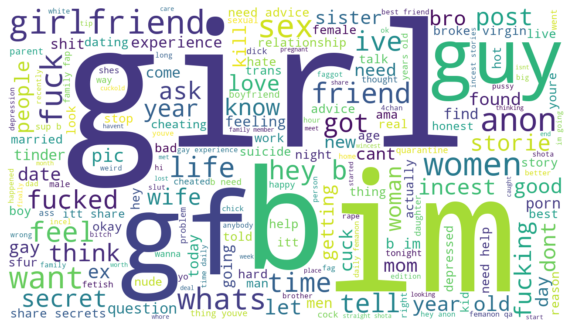

In [331]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==0)].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

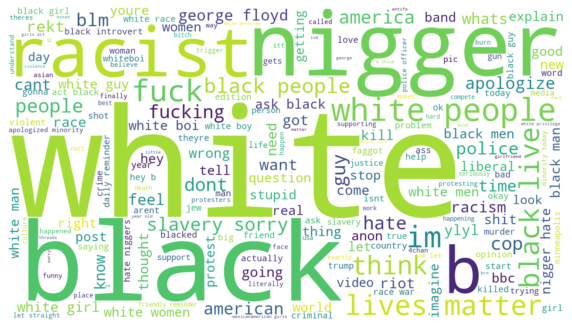

In [332]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==1)].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

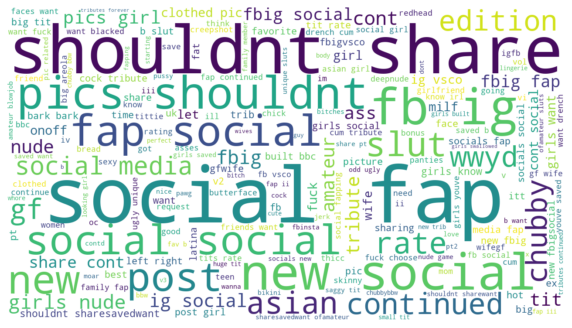

In [333]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==2) ].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

In [ ]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==3) ].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

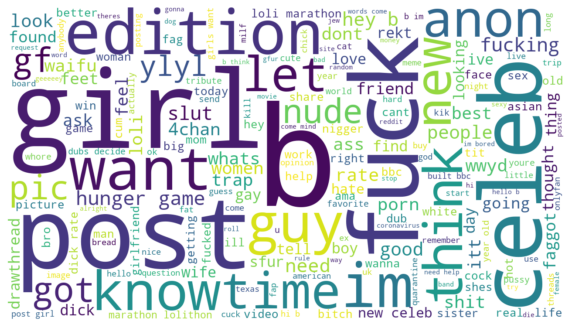

In [335]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==4) ].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

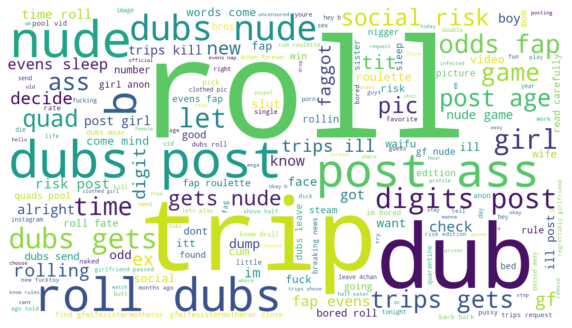

In [336]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==5)].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

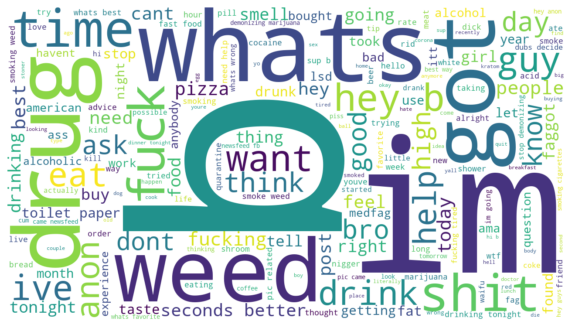

In [340]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==6) ].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

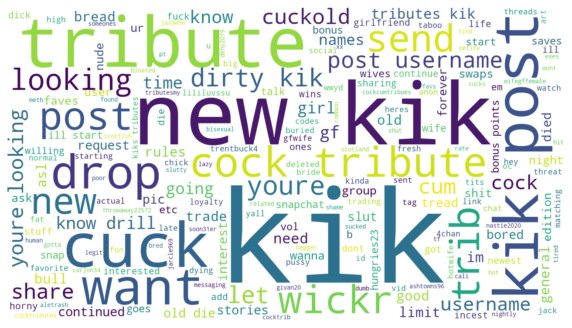

In [338]:
splits = [sem_url.split("-") for sem_url in stat_df_joined_cluster[(stat_df_joined_cluster.km ==7) ].semantic_url]
text = []
for split in splits:
    for word in split:
        if word not in nlp.nlp.Defaults.stop_words and word not in ['thread']:
            text.append(word)
wordcloud = WordCloud(width=1280, height=720, background_color="white", repeat=False).generate(" ".join(text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")